# Simulation of Decision making in the Medical domain

participants need to make 84 selection between slight improvement (level 1) for sure</br> 
or a chance for a moderate (level 2)</br>
significant (level 3)</br>
or complete recovery (level 4). </br>
However, each alternative treatment can result in complete paralysis (level 0).

In order to asses participant behavior I will try to compare 2 models:</br>
   1. a relation between the levels. Base on the formula y = x^b + a</br>
        in this formula a is the intercept and b is the slope.</br>
        slope = 1 will result in a linear correlation between the levels</br>
        slope < 1 will result in a concave relation, each improvement has less value</br>
        slope > 1 will result in an exponential slope, each improvement has higher value
        
   2. model 2 will assume only a monotonic relation with each level bigger than the other.</br>
        data inference from this model is less productive but it should have a good fit

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from scipy.special import expit
from scipy import stats, special
from scipy.optimize import minimize 

import pymc as pm
import arviz as az
import cmdstanpy

import matplotlib.pyplot as plt
import seaborn as sns

## Load the data and add the levels

In [2]:
db = pd.read_csv('data/sim.csv')
db['med']= np.where(db["value"] == 5, 1, 
                    np.where(db["value"] == 8, 2,
                            np.where(db["value"] == 12, 3, 4)))
db.head()                      

,Unnamed: 0,value,risk,ambiguity,med
0,0,5,0.25,0.00,1
1,1,5,0.50,0.50,1
2,2,12,0.50,0.74,3
3,3,25,0.50,0.74,4
4,4,8,0.50,0.50,2


## Simulate the data base on the formula of the first  model

In [3]:
n_subs = 50 # number of subs

α_true = np.random.beta(2, 4, n_subs) # the real alpha value, drown from a beta distribution 
α_true = α_true * 2 # times 2, as alpha can range from 0 to 2. average ~ 0.65
β_true = stats.truncnorm.rvs(-1.5, 1.5, 0.3, size = n_subs) # draw a beta from a turncate normal disterbution

# create values for medical decision
med_int = np.random.uniform(1,10,n_subs) # draw a random number participant value option 1
med_val = np.random.uniform(1,10,n_subs)
med_slp = np.random.gamma(1.1,1,n_subs) # draw a slope between 0 (concave) and 10 (exp)

# create an array 84 by number of participants
refValue = np.array([y for x in med_int for y in (x,) * db.shape[0]])
linslope = np.array([y for x in med_val for y in (x,) * db.shape[0]])
slope = np.array([y for x in med_slp for y in (x,) * db.shape[0]])

# calculate percieved value
value_per = refValue + linslope * np.tile(db.med, n_subs) ** slope
refPValue = refValue + linslope 

# get values for the model
value     = np.tile(np.array(db.med),       n_subs) # the levels (1-4)
risk      = np.tile(np.array(db.risk),      n_subs) # risk levels (0.25, 0.5, 0.75)
ambiguity = np.tile(np.array(db.ambiguity), n_subs) # ambiguity levels (0, 0.24, 0.5, 0.74)

# ref values 
refProbabilities = np.tile(1, len(value))
refAmbiguities   = np.tile(0,   len(value))


riskTol = np.repeat(α_true, len(risk) / n_subs)
ambTol  = np.repeat(β_true, len(ambiguity) / n_subs)

<AxesSubplot:ylabel='Count'>

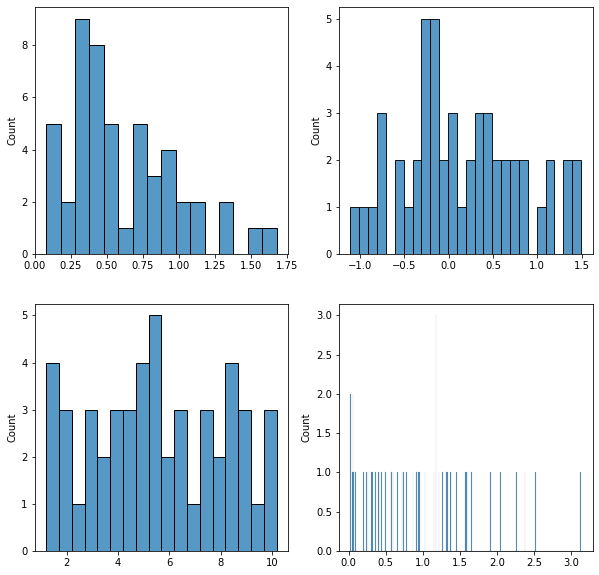

In [4]:
f, ax = plt.subplots(2,2, figsize=(10, 10))
sns.histplot(α_true, binwidth=0.1,ax=ax[0,0])
sns.histplot(β_true, binwidth=0.1,ax=ax[0,1])
sns.histplot(med_val, binwidth=0.5,ax=ax[1,0])
sns.histplot(med_slp, binwidth=0.01,ax=ax[1,1])

## Calculate probability and make choices 

In [5]:
uRef = refPValue ** riskTol
uLotto = (value_per ** riskTol) * (risk - (ambTol * ambiguity / 2))
p = sp.special.expit(uLotto - uRef)

choice = np.random.binomial(1, p, len(p))

In [6]:
sub_idx = np.arange(n_subs)
sub_idx = np.repeat(sub_idx, db.shape[0])
ID = sub_idx+1
n_trials = np.arange(len(choice))

simdata = pd.DataFrame({'sub': ID, 'choice': choice, 'value': value, 
                        'risk': risk, 'ambiguity': ambiguity, 'riskTol': riskTol, 'ambTol': ambTol,
                        'slope': slope,'p':p})
simdata.to_csv('data/sim_medical.csv')
simdata.head()

,sub,choice,value,risk,ambiguity,riskTol,ambTol,slope,p
0,1,0,1,0.25,0.00,0.31348,0.848331,0.09347,0.208394
1,1,0,1,0.50,0.50,0.31348,0.848331,0.09347,0.219743
2,1,0,3,0.50,0.74,0.31348,0.848331,0.09347,0.191555
3,1,0,4,0.50,0.74,0.31348,0.848331,0.09347,0.191906
4,1,0,2,0.50,0.50,0.31348,0.848331,0.09347,0.221137


In [7]:
simdata['l1'] = simdata.value > 0
simdata['l2'] = simdata.value > 1
simdata['l3'] = simdata.value > 2
simdata['l4'] = simdata.value > 3

simdata['l1'] = simdata['l1'].astype(int)
simdata['l2'] = simdata['l2'].astype(int)
simdata['l3'] = simdata['l3'].astype(int)
simdata['l4'] = simdata['l4'].astype(int)

simdata.head()

,sub,choice,value,risk,ambiguity,riskTol,ambTol,slope,p,l1,l2,l3,l4
0,1,0,1,0.25,0.00,0.31348,0.848331,0.09347,0.208394,1,0,0,0
1,1,0,1,0.50,0.50,0.31348,0.848331,0.09347,0.219743,1,0,0,0
2,1,0,3,0.50,0.74,0.31348,0.848331,0.09347,0.191555,1,1,1,0
3,1,0,4,0.50,0.74,0.31348,0.848331,0.09347,0.191906,1,1,1,1
4,1,0,2,0.50,0.50,0.31348,0.848331,0.09347,0.221137,1,1,0,0


In [8]:
with pm.Model() as RiskAmb_simple:
    
    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
   
    
    alpha = pm.Beta('alpha', 2,4, shape = n_subs)#alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', 0.3, 1, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    val = simdata['value'].values * α[sub_idx]
    svLotto = val * (simdata['risk'].values - (β[sub_idx] * (simdata['ambiguity'].values/2)))
    svRef = α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=simdata['choice'])
    trace_simple = pm.sample(4000, return_inferencedata=True, target_accept=0.95)#nuts={'target_accept':0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, alpha, β, γ]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 560 seconds.
There were 147 divergences after tuning. Increase `target_accept` or reparameterize.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
There were 208 divergences after tuning. Increase `target_accept` or reparameterize.
There were 265 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
with pm.Model() as RiskAmb_equ:
    
    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
   
    med_slope = pm.Gamma('med_slope', 1, 1, shape = n_subs)
    med_linslope = pm.Uniform('med_linslope', 1, 10, shape = n_subs)
    med_intercept = pm.Uniform('med_intercept', 1, 10, shape = n_subs)
    
    alpha = pm.Beta('alpha', 2,4, shape = n_subs)#alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', 0.3, 1, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    val = (med_intercept[sub_idx] + med_linslope[sub_idx] * simdata['value'].values ** med_slope[sub_idx]) ** α[sub_idx]
    svLotto = val * (simdata['risk'].values - (β[sub_idx] * (simdata['ambiguity'].values/2)))
    svRef = (med_intercept[sub_idx] + med_linslope[sub_idx]) ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=simdata['choice'])
    trace_equ = pm.sample(4000, return_inferencedata=True, target_accept=0.95)#nuts={'target_accept':0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, med_slope, med_linslope, med_intercept, alpha, β, γ]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2664 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8949, but should be close to 0.95. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
with pm.Model() as RiskAmb_unique:
    
    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
   
    level1 = pm.TruncatedNormal('level1', 5, 5, lower = 0, shape = n_subs )
    level2 = pm.TruncatedNormal('level2', 5, 5, lower = 0, shape = n_subs )
    level3 = pm.TruncatedNormal('level3', 5, 5, lower = 0, shape = n_subs )
    level4 = pm.TruncatedNormal('level4', 5, 5, lower = 0, shape = n_subs )
    
    alpha = pm.Beta('alpha', 2,4, shape = n_subs)#alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', 0.3, 1, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    val = simdata['l1'].values * level1[sub_idx] + simdata['l2'].values * level2[sub_idx] + simdata['l3'].values * level3[sub_idx] + simdata['l4'].values * level4[sub_idx]
        
    #val = (med_intercept[sub_idx] + med_linslope[sub_idx] * simdata['value'].values ** med_slope[sub_idx]) ** α[sub_idx]
    svLotto = (val ** α[sub_idx]) * (simdata['risk'].values - (β[sub_idx] * (simdata['ambiguity'].values/2)))
    svRef = level1[sub_idx] ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=simdata['choice'])
    trace_uniuqe = pm.sample(4000, return_inferencedata=True, target_accept=0.95)#nuts={'target_accept':0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, level1, level2, level3, level4, alpha, β, γ]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2203 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.


In [11]:
compare_dict = {"simple model": trace_simple, "equation": trace_equ, "unique": trace_uniuqe}
az.compare(compare_dict)

/home/nachshon/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/nachshon/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: divide by zero encountered in divide
  b_ary /= prior_bs * ary[int(n / 4 + 0.5) - 1]
/home/nachshon/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/stats/stats.py:1046: RuntimeWarning: invalid value encou

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
simple model,0,-2455.634317,53.273906,0.0,0.333333,22.062466,0.0,True,log
equation,1,NaN,NaN,NaN,0.333333,NaN,NaN,True,log
unique,2,NaN,NaN,NaN,0.333333,NaN,NaN,True,log


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>]], dtype=object)

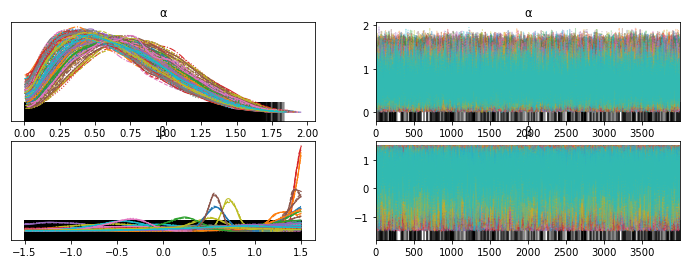

In [12]:
az.plot_trace(trace_simple, var_names=['α','β'])

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'med_intercept'}>,
        <AxesSubplot:title={'center':'med_intercept'}>],
       [<AxesSubplot:title={'center':'med_linslope'}>,
        <AxesSubplot:title={'center':'med_linslope'}>],
       [<AxesSubplot:title={'center':'med_slope'}>,
        <AxesSubplot:title={'center':'med_slope'}>]], dtype=object)

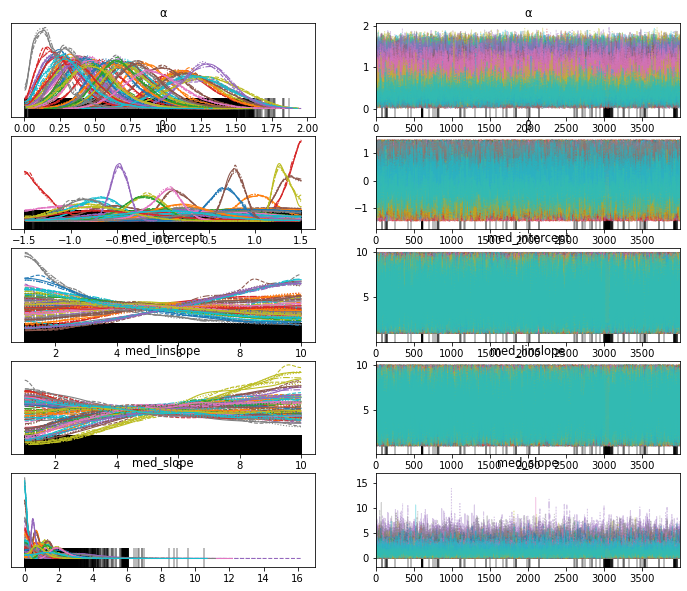

In [13]:
az.plot_trace(trace_equ, var_names=['α','β','med_intercept','med_linslope', 'med_slope'])

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'level4'}>,
        <AxesSubplot:title={'center':'level4'}>],
       [<AxesSubplot:title={'center':'level3'}>,
        <AxesSubplot:title={'center':'level3'}>],
       [<AxesSubplot:title={'center':'level2'}>,
        <AxesSubplot:title={'center':'level2'}>],
       [<AxesSubplot:title={'center':'level1'}>,
        <AxesSubplot:title={'center':'level1'}>]], dtype=object)

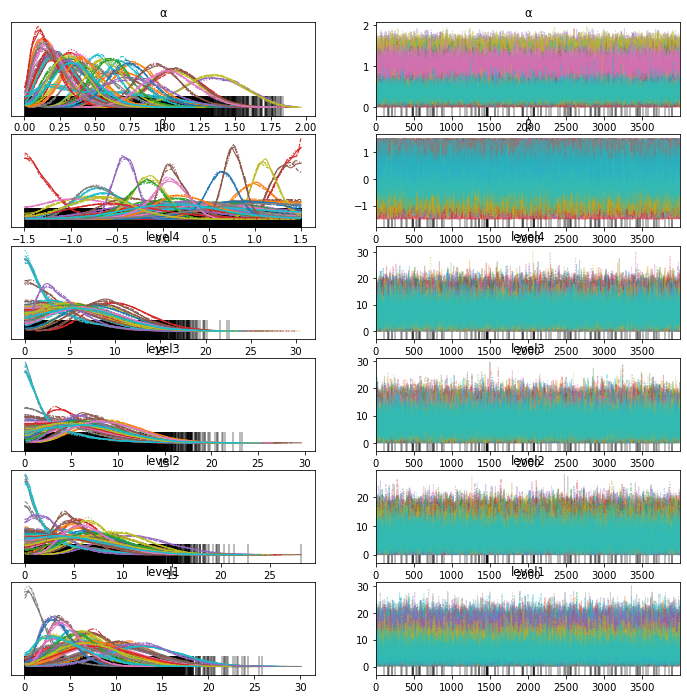

In [14]:
az.plot_trace(trace_uniuqe, var_names=['α','β', 'level4', 'level3', 'level2', 'level1'])

In [15]:
df = simdata
subs = df['sub'].unique()

α_pymc_s = az.summary(trace_simple, var_names=['α'])['mean']
β_pymc_s = az.summary(trace_simple, var_names=['β'])['mean']
α_pymc_e = az.summary(trace_equ, var_names=['α'])['mean']
β_pymc_e = az.summary(trace_equ, var_names=['β'])['mean']
α_pymc_u = az.summary(trace_uniuqe, var_names=['α'])['mean']
β_pymc_u = az.summary(trace_uniuqe, var_names=['β'])['mean']


outcome = pd.DataFrame({'subs':subs,
                        'α_true': α_true,  'α_simple': α_pymc_s.values, 'α_equ': α_pymc_e.values, 'α_unique': α_pymc_u.values,
                        'β_true': β_true,  'β_simple': β_pymc_s.values, 'β_equ': β_pymc_e.values, 'β_unique': β_pymc_u.values
                        })

outcome.corr()

,subs,α_true,α_simple,α_equ,α_unique,β_true,β_simple,β_equ,β_unique
subs,1.000000,-0.080631,-0.077538,-0.143331,-0.063266,-0.019451,-0.020753,-0.105806,-0.082460
α_true,-0.080631,1.000000,0.536124,0.898851,0.804755,-0.077910,-0.040315,0.159771,0.129682
α_simple,-0.077538,0.536124,1.000000,0.577332,0.858075,0.214068,0.039986,0.233098,0.188093
α_equ,-0.143331,0.898851,0.577332,1.000000,0.816944,-0.030071,0.016493,0.136543,0.100899
α_unique,-0.063266,0.804755,0.858075,0.816944,1.000000,0.110718,-0.122675,0.216254,0.168326
β_true,-0.019451,-0.077910,0.214068,-0.030071,0.110718,1.000000,0.634285,0.783265,0.780181
β_simple,-0.020753,-0.040315,0.039986,0.016493,-0.122675,0.634285,1.000000,0.703673,0.710559
β_equ,-0.105806,0.159771,0.233098,0.136543,0.216254,0.783265,0.703673,1.000000,0.995553
β_unique,-0.082460,0.129682,0.188093,0.100899,0.168326,0.780181,0.710559,0.995553,1.000000


In [16]:
α_pymc = az.summary(trace_equ, var_names=['α'])['mean']
β_pymc = az.summary(trace_equ, var_names=['β'])['mean']
mi_pymc = az.summary(trace_equ, var_names=['med_intercept'])['mean']
ml_pymc = az.summary(trace_equ, var_names=['med_linslope'])['mean']
ms_pymc = az.summary(trace_equ, var_names=['med_slope'])['mean']

outcome2 = pd.DataFrame({'subs':subs,
                         'α_true': α_true,  'α_pymc': α_pymc.values,
                         'β_true': β_true,  'β_pymc': β_pymc.values, 
                         'mint_true': med_int, 'mint_pymc': mi_pymc.values,
                         'mls_true': med_slp, 'mls_pymc': ml_pymc.values,
                         'mslope_true': med_slp, 'mslope_pymc': ms_pymc.values})

outcome2.corr()

,subs,α_true,α_pymc,β_true,β_pymc,mint_true,mint_pymc,mls_true,mls_pymc,mslope_true,mslope_pymc
subs,1.000000,-0.080631,-0.143331,-0.019451,-0.105806,-0.134949,-0.168850,0.008697,-0.127700,0.008697,0.094137
α_true,-0.080631,1.000000,0.898851,-0.077910,0.159771,0.137044,0.398149,0.197775,0.762002,0.197775,0.383348
α_pymc,-0.143331,0.898851,1.000000,-0.030071,0.136543,0.295635,0.560925,0.145433,0.824317,0.145433,0.225308
β_true,-0.019451,-0.077910,-0.030071,1.000000,0.783265,-0.036954,0.073618,0.064639,-0.097959,0.064639,0.081067
β_pymc,-0.105806,0.159771,0.136543,0.783265,1.000000,0.102345,0.226770,0.041761,0.010151,0.041761,0.063126
mint_true,-0.134949,0.137044,0.295635,-0.036954,0.102345,1.000000,0.501245,-0.099840,0.088070,-0.099840,-0.374507
mint_pymc,-0.168850,0.398149,0.560925,0.073618,0.226770,0.501245,1.000000,-0.426733,0.089269,-0.426733,-0.503245
mls_true,0.008697,0.197775,0.145433,0.064639,0.041761,-0.099840,-0.426733,1.000000,0.352759,1.000000,0.779988
mls_pymc,-0.127700,0.762002,0.824317,-0.097959,0.010151,0.088070,0.089269,0.352759,1.000000,0.352759,0.412009
mslope_true,0.008697,0.197775,0.145433,0.064639,0.041761,-0.099840,-0.426733,1.000000,0.352759,1.000000,0.779988


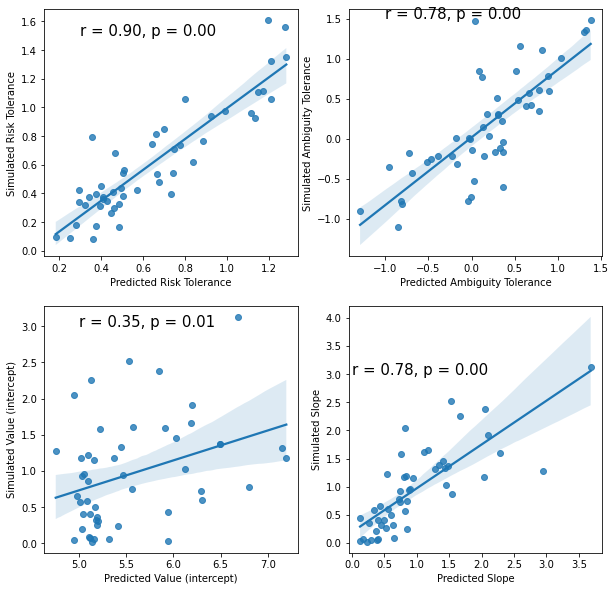

In [17]:
f, ax = plt.subplots(2,2, figsize=(10, 10))

sns.regplot(x = 'α_pymc',      y = 'α_true',       data = outcome2, ax=ax[0,0])
sns.regplot(x = 'β_pymc',      y = 'β_true',       data = outcome2, ax=ax[0,1])
sns.regplot(x = 'mls_pymc',   y = 'mls_true',      data = outcome2, ax=ax[1,0])
sns.regplot(x = 'mslope_pymc', y = 'mslope_true',  data = outcome2, ax=ax[1,1])


ax[0,0].set(xlabel='Predicted Risk Tolerance',      ylabel='Simulated Risk Tolerance')
ax[0,1].set(xlabel='Predicted Ambiguity Tolerance', ylabel='Simulated Ambiguity Tolerance')
ax[1,0].set(xlabel='Predicted Value (intercept)',   ylabel='Simulated Value (intercept)')
ax[1,1].set(xlabel='Predicted Slope',               ylabel='Simulated Slope')

corr = (sp.stats.pearsonr(outcome2.α_pymc, outcome2.α_true))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0,0].text(.3, 1.5, text, fontsize=15)

corr = (sp.stats.pearsonr(outcome2.β_pymc, outcome2.β_true))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[0,1].text(-1, 1.5, text, fontsize=15)

corr = (sp.stats.pearsonr(outcome2.mls_pymc, outcome2.mls_true))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1,0].text(5, 3, text, fontsize=15)

corr = (sp.stats.pearsonr(outcome2.mslope_pymc, outcome2.mslope_true))
text = 'r = {:.2f}, p = {:.2f}'.format(corr[0],corr[1])
ax[1,1].text(0, 3, text, fontsize=15)

plt.show()